# Data block foundations, in Swifty/functional style

In [ ]:
%install-location $cwd/swift-install
%install '.package(path: "$cwd/FastaiNotebook_07_batchnorm")' FastaiNotebook_07_batchnorm
%install '.package(path: "$cwd/SwiftCV")' SwiftCV

Installing packages:
	.package(path: "/home/ubuntu/fastai_docs/dev_swift/FastaiNotebook_07_batchnorm")
		FastaiNotebook_07_batchnorm
	.package(path: "/home/ubuntu/fastai_docs/dev_swift/SwiftCV")
		SwiftCV
With SwiftPM flags: []
Working in: /tmp/tmpayabt4ji/swift-install
Compile Swift Module 'jupyterInstalledPackages' (1 sources)
Initializing Swift...
Installation complete!


In [ ]:
import Path
import TensorFlow
import Python

In [ ]:
import FastaiNotebook_07_batchnorm

In [ ]:
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

('inline', 'module://ipykernel.pylab.backend_inline')


## DataBlock-like manipulation in a lightweight functional, Swifty style

The DataBlock API in Python is designed to help with the routine data manipulations involved in modelling: downloading data, loading it given an understanding of its layout on the filesystem, processing it, and feeding it into an ML framework like fastai. This is a data pipeline. How do we do this in Swift?

One approach is to build a set of types (structs, protocols, etc.) which represent various stages of this pipeline. By making the types generic, we could build a library that handled data for many kinds of models. However, it is sometimes a good rule of thumb, before writing generic types, to start by writing concrete types and then to notice what to abstract into a generic later. And another good rule of thumb, before writing concrete types, is to write no types at all, and to see how far you can get with a more primitive tool for composition: functions.

This notebook shows how to perform DataBlock-like operations using a _lightweight functional style_. This means, first, to rely as much as possible on _pure_ functions -- that is, functions which do nothing but return outputs based on their inputs, and which don't mutate values anywhere. Second, in particular, it means to use Swift's support for _higher-order functions_ (functions which take functions, like `map`, `filter`, `reduce`, and `compose`). Finally, this example relies on _tuples_. Like structs, tuples can have named, typed properties. Unlike structs, you don't need to name them. They can be a fast, ad-hoc way to explore the data types that you actually need, without being distracted by considering what's a method, an initializer, etc.,

Swift has excellent, understated support for a such a style. 

## Getting Started

First things first, we need to download Imagenette and untar it. What follows is very close to what we did for MNIST.

In [ ]:
public let dataPath = Path.home/".fastai"/"data"

In [ ]:
public func downloadImagenette(path: Path = dataPath, sz:String="-320") -> Path {
    let url = "https://s3.amazonaws.com/fast-ai-imageclas/imagenette\(sz).tgz"
    let fname = "imagenette\(sz)"
    let file = path/fname
    try! path.mkdir(.p)
    if !file.exists {
        downloadFile(url, dest:(path/"\(fname).tgz").string)
        _ = "/bin/tar".shell("-xzf", (path/"\(fname).tgz").string, "-C", path.string)
    }
    return file
}

In [ ]:
//export
public func collectFiles(under path: Path, recurse: Bool = false, filtering extensions: [String]? = nil) -> [Path] {
    var res: [Path] = []
    for p in try! path.ls(){
        if p.kind == .directory && recurse { 
            res += collectFiles(under: p.path, recurse: recurse, filtering: extensions)
        } else if extensions == nil || extensions!.contains(p.path.extension.lowercased()) {
            res.append(p.path)
        }
    }
    return res
}

To build our dataset, we need, at the core, only four functions that tells us:
- how do we dowload the dataset
- how do we get the inputs
- how do we split them between train and valid
- how do we label them

We put those four requirements in a `DatasetConfig` protocol.

In [ ]:
public protocol DatasetConfig {
    associatedtype Item
    associatedtype Label
    
    static func download() -> Path
    static func getItems(_ path: Path) -> [Item]
    static func isTraining(_ item: Item) -> Bool
    static func labelOf(_ item: Item) -> Label
}

Here is what we know ahead of time about how imagenette data is laid out on disk:

```
.
└── data                                           # <-- this is the fastai data root path
    ├── imagenette-160                             # <-- this is the imagenette dataset path
    │   ├── train                                  # <-- the train/ and val/ dirs are our two segments
    │   │   ├── n01440764                          # <-- this is an image category _label_
    │   │   │   ├── n01440764_10026.JPEG           # <-- this is an image (a _sample_) with that label
    │   │   │   ├── n01440764_10027.JPEG
    │   │   │   ├── n01440764_10042.JPEG
   ...
    │   ├── val
    │       └── n03888257
    │           ├── ILSVRC2012_val_00001440.JPEG
    │           ├── ILSVRC2012_val_00002508.JPEG
   ...  

```


We will define one type, an `enum`, to capture this information.

This "empty" `enum` will serve only as a namespace, a grouping, for pure functions representing this information. By putting this information into one type, our code is more modular: it more clearly distinguishes facts about _this dataset_, from _general purpose data manipulators_, from _computations for this analysis_.

Here's our Imagenette configuration type:

In [ ]:
enum ImageNette: DatasetConfig {
    
    public static func download() -> Path { return downloadImagenette() }
    
    public static func getItems(_ path: Path) -> [Path] {
        return collectFiles(under: path, recurse: true, filtering: ["jpeg", "jpg"])
    }
    
    public static func isTraining(_ p:Path) -> Bool {
        return p.parent.parent.basename() == "train"
    }
    
    public static func labelOf(_ p:Path) -> String { return p.parent.basename() }
}


From this configuration, we can get values by calling the `download`  and `getItems` function. This step would be exactly the same for all datasets:

In [ ]:
let path = ImageNette.download()
let allFnames = ImageNette.getItems(path)

This function will use our dataset configuration to describe a given item:

In [ ]:
func describeSample<C>(_ item: C.Item, config: C.Type) where C: DatasetConfig {
    let isTraining = C.isTraining(item)
    let label = C.labelOf(item)
    print("""
          item: \(item)
          training?:  \(isTraining)
          label: \(label)
          """)
}

In [ ]:
describeSample(allFnames[0], config: ImageNette.self)

item: /home/ubuntu/.fastai/data/imagenette-320/val/n03888257/ILSVRC2012_val_00016387.JPEG
training?:  false
label: n03888257


We can see that our functions for _path->isTraining_ and _path->label_ are working as expected.

### Split the data

Now we want to split our samples into a training and validation sets. Since this is so routine we define a standard function that does so.

It is enough to take an array and returns a named tuple of two arrays, one for training and one for validation.

In [ ]:
func partitionIntoTrainVal<T>(_ items:[T],isTrain:((T)->Bool)) -> (train:[T],valid:[T]){
    return (train: items.filter(isTrain), valid: items.filter { !isTrain($0) })
}

In [ ]:
var samples = partitionIntoTrainVal(allFnames, isTrain:ImageNette.isTraining)

And verify that it works as expected:

In [ ]:
describeSample(samples.valid.randomElement()!, config: ImageNette.self)

item: /home/ubuntu/.fastai/data/imagenette-320/val/n02979186/ILSVRC2012_val_00008651.JPEG
training?:  false
label: n02979186


In [ ]:
describeSample(samples.train.randomElement()!, config: ImageNette.self)

item: /home/ubuntu/.fastai/data/imagenette-320/train/n03425413/n03425413_13672.JPEG
training?:  true
label: n03425413


### Process the data

We process the data by taking all training labels, uniquing them, sorting them, and then defining an integer to represent the label.

Those numerical labels let us define two functions, a function for label->number and the inverse function number->label.

But notable point is that the process that produces those functions _is also a function_: the input is a list of training labels, and the output is the label<->number bidirectional mappings.

That function which creates the bidirectional mapping is called `initState` below. Those steps are generic and might be applied for other tasks, so we define another protocol for them.

In [ ]:
public protocol Processor {
    associatedtype Input
    associatedtype Output
    
    mutating func initState(_ items: [Input])
    func process  (_ item: Input)  -> Output
    func deprocess(_ item: Output) -> Input
}

And the specific `CategoryProcessor` we need in this case.

In [ ]:
public struct CategoryProcessor: Processor {
    private(set) public var intToLabel: [String] = []
    private(set) public var labelToInt: [String:Int] = [:]
    
    public mutating func initState(_ items: [String]) {
        intToLabel = Array(Set(items)).sorted()
        labelToInt = Dictionary(uniqueKeysWithValues:
            intToLabel.enumerated().map({ ($0.element, $0.offset) }))
    }
    
    public func process(_ item: String) -> Int { return labelToInt[item]! }
    public func deprocess(_ item: Int) -> String { return intToLabel[item] }
}

Let us create a labelNumber mapper from the training data. First we use the function `labelOf` to get all the training labels, then we can initialize a `CategoryProcessor`.

In [ ]:
var trainLabels = samples.train.map(ImageNette.labelOf)
var labelMapper = CategoryProcessor()
labelMapper.initState(trainLabels)

The labelMapper now supplies the two bidirectional functions. We can verify they have the required inverse relationship:

In [ ]:
var randomLabel = labelMapper.intToLabel.randomElement()!
print("label = \(randomLabel)")
var numericalizedLabel = labelMapper.process(randomLabel)
print("number = \(numericalizedLabel)")
var labelFromNumber = labelMapper.deprocess(numericalizedLabel)
print("label = \(labelFromNumber)")

label = n03888257
number = 9
label = n03888257


### Label the data

Now we are in a position to give the data numerical labels.

Now in order to map from a sample item (a `Path`), to a numerical label (an `Int`), we just compose our Path->label function with a label->int function. Curiously, Swift does not define its own compose function, so we defined a `compose` operator `>|` ourselves. We can use it to create our new function as a composition explicitly:

In [ ]:
// export
public func >| <A, B, C>(_ lhs: @escaping (A) -> B,
                   _ rhs: @escaping (B) -> C) -> (A) -> C {
    return { rhs(lhs($0)) }
}

The we define a function which map a raw sample (`Path`) to a numericalized label (`Int`)

In [ ]:
var pathToNumericalizedLabel = ImageNette.labelOf >| labelMapper.process

Now we can, if we wish, compute numericalized labels over all the training and validation items:

In [ ]:
var trainNumLabels = samples.train.map(pathToNumericalizedLabel)
var validNumLabels = samples.valid.map(pathToNumericalizedLabel)

We've gotten pretty far just using mostly just variables, functions, and function composition. But one downside is that our results are now scattered over a few different variables, `samples`, `trainNumLabels`, `valNumLabels`. We collect these values into one structure for convenience:

In [ ]:
struct SplitLabeledData<Item,Label> {
    var train: [(x: Item, y: Label)]
    var valid: [(x: Item, y: Label)]
    
    init(train: [(x: Item, y: Label)], valid: [(x: Item, y: Label)]) {
        (self.train,self.valid) = (train,valid)
    }
}

And we can define a convenience function to build it directly from our config and a processor.

In [ ]:
public func makeSLD<C, P>(config: C.Type, procL: inout P) -> SplitLabeledData<C.Item, P.Output> 
where C: DatasetConfig, P: Processor, P.Input == C.Label{
    let path = C.download()
    let items = C.getItems(path)
    let samples = partitionIntoTrainVal(items, isTrain:C.isTraining)
    let trainLabels = samples.train.map(C.labelOf)
    procL.initState(trainLabels)
    let itemToProcessedLabel = C.labelOf >| procL.process
    return SplitLabeledData(train: samples.train.map { ($0, itemToProcessedLabel($0)) },
                            valid: samples.valid.map { ($0, itemToProcessedLabel($0)) })
}

In [ ]:
var procL = CategoryProcessor()
let sld = makeSLD(config: ImageNette.self, procL: &procL)

### Opening images

We can use the same compose approach to convert our images from `Path` filenames to resized images.

In [ ]:
import Foundation
import SwiftCV

First let's open those images with openCV:

In [ ]:
func openImage(_ fn: Path) -> Mat {
    return imdecode(try! Data(contentsOf: fn.url))
}

And add a convenience function to have a look.

In [ ]:
func showCVImage(_ img: Mat) {
    let tensImg = Tensor<UInt8>(cvMat: img)!
    let numpyImg = tensImg.makeNumpyArray()
    plt.imshow(numpyImg) 
    plt.axis("off")
    plt.show()
}

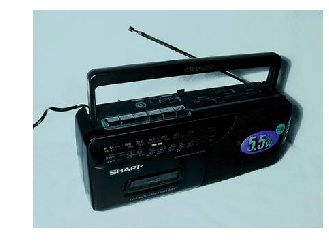

In [ ]:
showCVImage(openImage(sld.train.randomElement()!.x))

The channels are in BGR instead of RGB so we first switch them with openCV

In [ ]:
func BGRToRGB(_ img: Mat) -> Mat {
    return cvtColor(img, nil, ColorConversionCode.COLOR_BGR2RGB)
}

Then we can resize them

In [ ]:
func resize(_ img: Mat, size: Int) -> Mat {
    return resize(img, nil, Size(size, size), 0, 0, InterpolationFlag.INTER_LINEAR)
}

With our compose operator, the succession of transforms can be written in this pretty way:

In [ ]:
let transforms = openImage >| BGRToRGB >| { resize($0, size: 224) }

And we can have a look at one of our elements:

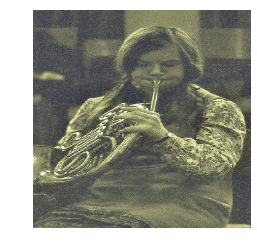

In [ ]:
showCVImage(transforms(sld.train.randomElement()!.x))

## Conversion to Tensor and batching

Now we will need tensors to train our model, so we need to convert our images and ints to tensors.

In [ ]:
func cvImgToTensor(_ img: Mat) -> TF {
    return TF(Tensor<UInt8>(cvMat: img)!) / 255.0
}

We compose our transforms with that last function to get tensors.

In [ ]:
let pathToTF = transforms >| cvImgToTensor

In [ ]:
func intTOTI(_ i: Int) -> TI { return TI(Int32(i)) } 

Now we define a `Batcher` that will be responsible for creating minibatches as an iterator. It has the properties you know from PyTorch (batch size, num workers, shuffle) and will use multiprocessing to gather the images in parallel.

To be able to write `for batch in Batcher(...)`, `Batcher` needs to conform to `Sequence`, which means it needs to have a `makeIterator` function. That function has to return another struct that conforms to `IteratorProtocol`. The only thing required there is a `next` property that returns the next batch (or `nil` if we are finished).

The code is pretty striaghtforward: we shuffle the dataset at each beginning of iteration if we want, then we apply the transforms in parallel with the use of `concurrentMap`, that works just like map but with `numWorkers` processes.

In [ ]:
struct Batcher<Item,Label,ScalarI,ScalarL>: Sequence 
where ScalarI: TensorFlowScalar, ScalarL: TensorFlowScalar{
    let dataset: [(Item, Label)]
    let xToTensor: (Item) -> Tensor<ScalarI>
    let yToTensor: (Label) -> Tensor<ScalarL>
    var bs: Int = 64
    var numWorkers: Int = 4
    var shuffle: Bool = false
    
    init(_ ds: [(Item, Label)], 
         xToTensor: @escaping (Item) -> Tensor<ScalarI>, 
         yToTensor: @escaping (Label) ->  Tensor<ScalarL>,
         bs: Int = 64, numWorkers: Int = 4, shuffle: Bool = false) {
        (dataset,self.xToTensor,self.yToTensor,self.bs) = (ds,xToTensor,yToTensor,bs)
        (self.numWorkers,self.shuffle) = (numWorkers,shuffle)
    }
    
    func makeIterator() -> BatchIterator<Item,Label,ScalarI,ScalarL> { 
        return BatchIterator(self, numWorkers: numWorkers, shuffle: shuffle)
    }
}

struct BatchIterator<Item,Label,ScalarI,ScalarL>: IteratorProtocol 
where ScalarI: TensorFlowScalar, ScalarL: TensorFlowScalar{
    let b: Batcher<Item,Label,ScalarI,ScalarL>
    var numWorkers: Int = 4
    private var idx: Int = 0
    private var ds: [(Item, Label)]
    
    init(_ batcher: Batcher<Item,Label,ScalarI,ScalarL>, numWorkers: Int = 4, shuffle: Bool = false){ 
        (b,self.numWorkers,idx) = (batcher,numWorkers,0) 
        self.ds = shuffle ? b.dataset.shuffled() : b.dataset
    }
    
    mutating func next() -> (xb:Tensor<ScalarI>, yb:Tensor<ScalarL>)? {
        guard idx < b.dataset.count else { return nil }
        let end = idx + b.bs < b.dataset.count ? idx + b.bs : b.dataset.count 
        let samples = Array(ds[idx..<end])
        idx += b.bs
        return (xb: Tensor<ScalarI>(concatenating: samples.concurrentMap(nthreads: numWorkers) { 
            self.b.xToTensor($0.0).expandingShape(at: 0) }), 
                yb: Tensor<ScalarL>(concatenating: samples.concurrentMap(nthreads: numWorkers) { 
            self.b.yToTensor($0.1).expandingShape(at: 0) }))
    }
    
}

In [ ]:
SetNumThreads(0)

In [ ]:
let batcher = Batcher(sld.train, xToTensor: pathToTF, yToTensor: intTOTI, bs:256, shuffle:true)

In [ ]:
time {var c = 0
      for batch in batcher { c += 1 }
     }

average: 14313.914632 ms,   min: 14313.914632 ms,   max: 14313.914632 ms


In [ ]:
let firstBatch = batcher.first(where: {_ in true})!

In [ ]:
func showTensorImage(_ img: TF) {
    let numpyImg = img.makeNumpyArray()
    plt.imshow(numpyImg) 
    plt.axis("off")
    plt.show()
}

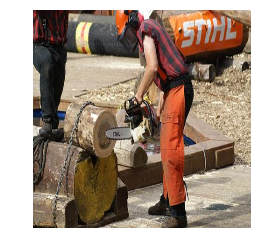

In [ ]:
showTensorImage(firstBatch.xb[0])